In [18]:
# Intro to Data Science Project
# Muhammad Azmat | 23i-2651
# Abdullah Ilyas | 23i-2603
# DS-C


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# MODULE 1


file_location = 'electronics.json'
df = pd.read_json(file_location)

# checking the missing values to see how to refine, and clean the data

# print("Missing values in each column:")
# print(df.isnull().sum())

numeric_cols = df.select_dtypes(include='number').columns # selecting only numerical data
df[numeric_cols] = df[numeric_cols].apply(lambda func: func.fillna(func.mean())) # here we are filling the missing values of each col with the mean of that col

# inplace makes changes to the datset without assigning a change to a new variable

# this is for rows
threshold = len(df.columns) // 2  # 50 % threshold
df.dropna(thresh=threshold, inplace=True)


# this is for columns
missing_percentge = df.isnull().sum() / len(df)
useless_cols = missing_percentge[missing_percentge > 0.3].index # if a col has more than 30% missing values, drop it
df.drop(columns=useless_cols, inplace=True)

# print(" The Cleaned dataset is :: ")
# print(df)

# dealing with the 2nd point, i.e. dealing with extreme values i.e. OUTLIERS

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1 # same formula as prob course

    if IQR == 0:
        print(f"Column '{col}' has zero IQR. The data in this column is constant.")
        # lower_bound = Q1  # Since the column is constant, lower and upper bounds are the same
        # upper_bound = Q3
        continue

    # same formula as in prob course
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    print(f"Number of outliers in '{col}': {len(outliers)}")


    print(f"Lower bound: {lower_bound}, Upper bound: {upper_bound}")
    print(f"Number of outliers: {len(outliers)}")

    # plotting
    plt.figure(figsize=(10, 5))
    plt.boxplot(df[col].dropna(), vert=False)
    plt.title(f"Boxplot for {col}")
    plt.xlabel(col)
    plt.show()

    # Optionally, remove outliers
    retain_outliers = input(f"Do you want to retain outliers in {col}? (yes/no): ").strip().lower()
    if retain_outliers == 'no':
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]

# print("The dataset after handling outliers:")
# print(df)

# creating new features

df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'], errors='coerce')

print(f"Missing Purchase Dates: {df['Purchase_Date'].isna().sum()}")
df = df.dropna(subset=['Purchase_Date']) 

df['Purchase_Year_Month'] = df['Purchase_Date'].dt.to_period('M') # purchase date se extract kro, aur purchase month, day mein dal lou

purchase_frequency = df.groupby(['Customer_ID', 'Purchase_Year_Month'])['Transaction_ID'].nunique().reset_index() # calc purchase frequency per month
purchase_frequency.rename(columns={'Transaction_ID': 'Purchase_Frequency_Per_Month'}, inplace=True)

df = df.merge(purchase_frequency[['Customer_ID', 'Purchase_Year_Month', 'Purchase_Frequency_Per_Month']], 
              on=['Customer_ID', 'Purchase_Year_Month'], how='left') # merge into main df 

# Ensure the dataframe columns exist before accessing them
if 'Customer_ID' in df.columns and 'Purchase_Year_Month' in df.columns and 'Purchase_Frequency_Per_Month' in df.columns:
    print(df[['Customer_ID', 'Purchase_Year_Month', 'Purchase_Frequency_Per_Month']].head())
else:
    print("One or more required columns are missing from the dataframe.")


# now we are normalising and standardizing our numerical data

scaler = StandardScaler()

# Apply standardization to the numeric columns
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

print("Standardized Data (first 5 rows):")
print(df[numeric_cols].head())

# here we use min max normalization to standardize the values , we standardize it to make well distributed range/intervals
scaler_minmax = MinMaxScaler()
df[numeric_cols] = scaler_minmax.fit_transform(df[numeric_cols])

print("Normalized Data (first 5 rows):")
print(df[numeric_cols].head())




Column 'Will_Purchase_Next_Month' has zero IQR. The data in this column is constant.
Missing Purchase Dates: 48
One or more required columns are missing from the dataframe.
Standardized Data (first 5 rows):
   Will_Purchase_Next_Month
0                  0.381586
1                  0.381586
2                  0.381586
3                  0.381586
4                  0.381586
Normalized Data (first 5 rows):
   Will_Purchase_Next_Month
0                       1.0
1                       1.0
2                       1.0
3                       1.0
4                       1.0



Descriptive Statistics:
       Purchase_Amount
count              952
unique             412
top                   
freq                31


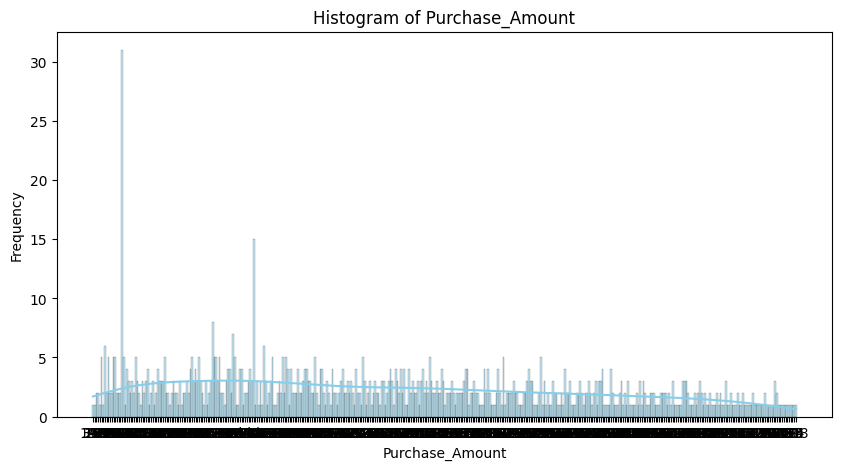

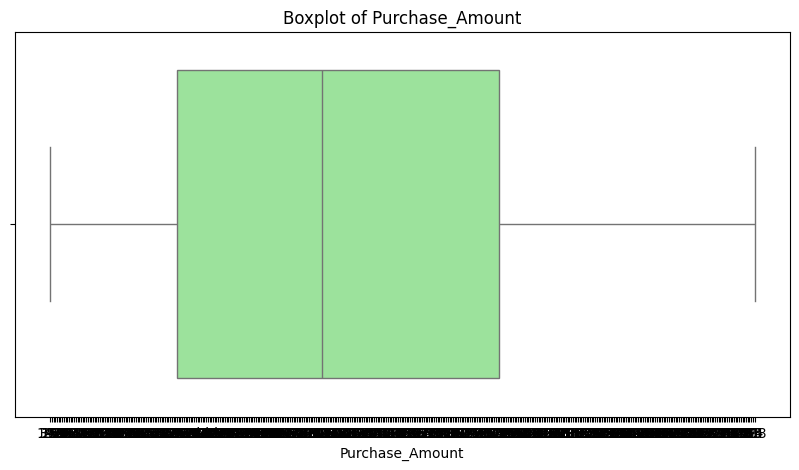

Skewness of key features:
Purchase_Amount: 0.05
Purchase_Amount has minimal skew.

Purchase_Amount:
Lower Bound: -216.00, Upper Bound: 720.00
Number of outliers: 0


C:\Users\Hp Pavilion 13 Aero\AppData\Local\Temp\ipykernel_18048\164907771.py:50: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[feature].fillna(df[feature].mean(), inplace=True)  # missing cols ko col ke values ke mean se replace kar diya


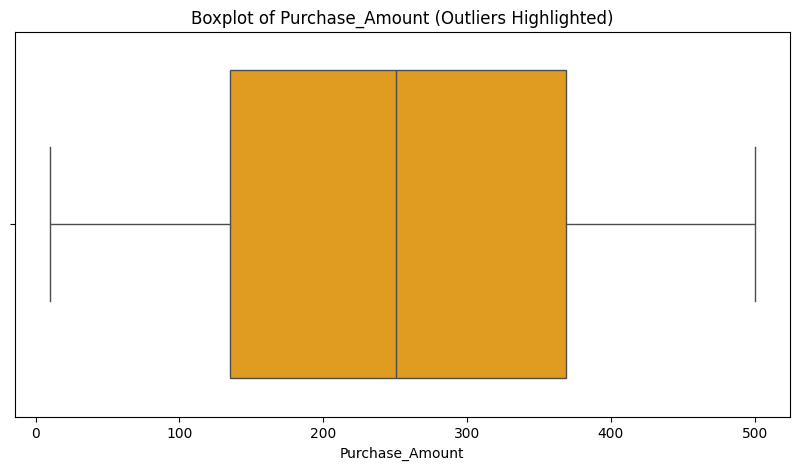

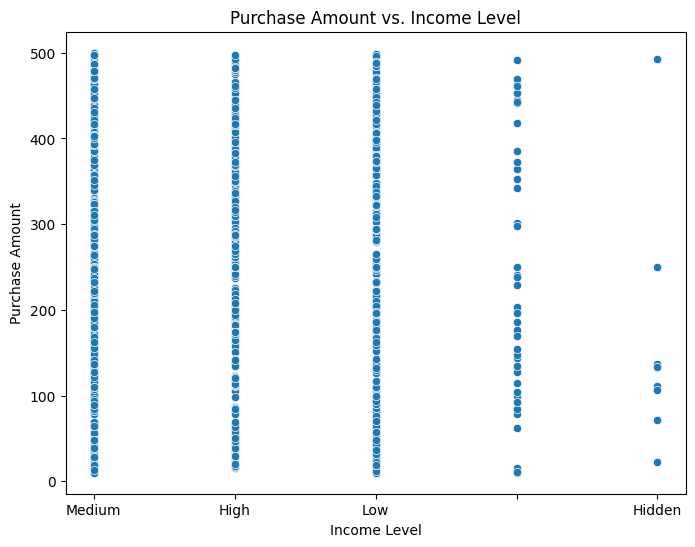

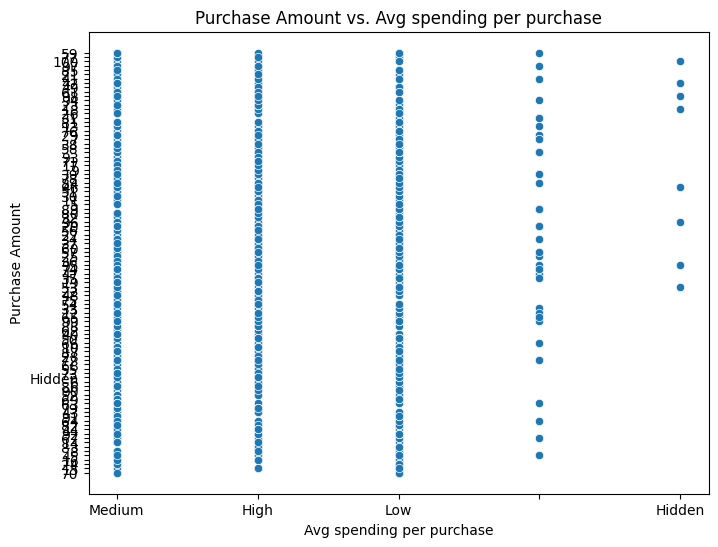

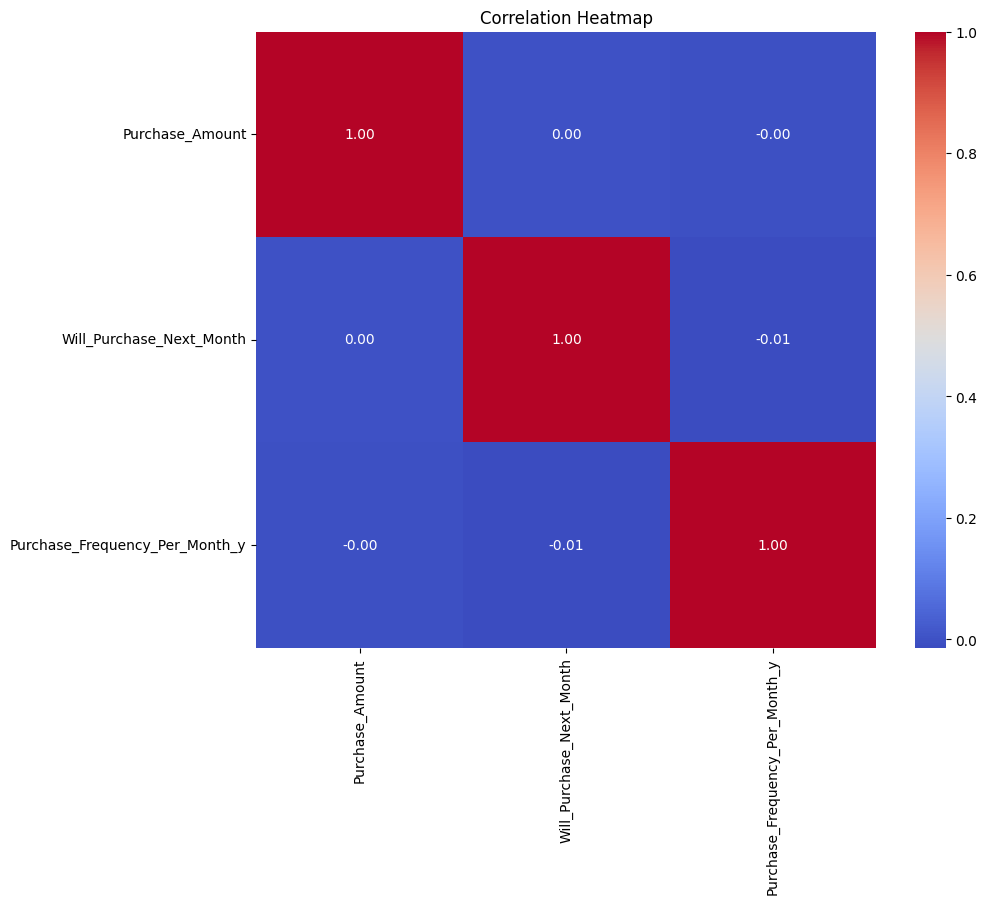

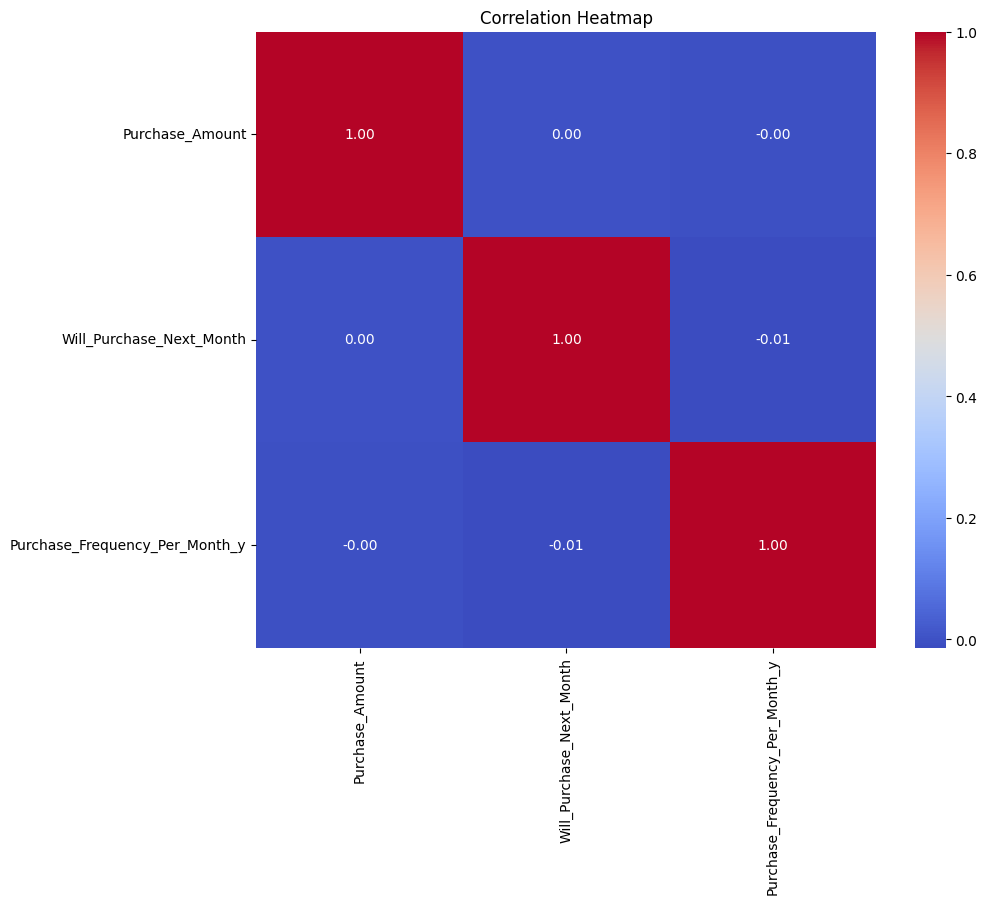



Strong Positive Correlations (Threshold > 0.5):
No strong positive correlations found.


Strong Negative Correlations (Threshold < -0.5):
No strong negative correlations found.


No strong correlations found. Weak correlations:
Series([], dtype: float64)
Missing columns required for analysis: ['Purchase_Frequency_Per_Month']
Missing columns required for analysis: ['Purchase_Frequency_Per_Month']


In [19]:
# module 2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose


# part i is to analyze the distribution of key features like customer age, purchase amount, and purchase frequency using histograms, boxplots, and descriptive statistics

key_features = ['Customer_Age', 'Purchase_Amount', 'Purchase_Frequency_Per_Month']

# Check if the features exist in the dataset
key_features = [col for col in key_features if col in df.columns]

print("")
print("Descriptive Statistics:")
print(df[key_features].describe()) # .describe() describes the main main features of the cols

# displaying
for feature in key_features:
    if feature not in df.columns:
        print(f"{feature} not found in the dataset.")
        continue
    # historgram tells distribution (importance) of a cont variable
    plt.figure(figsize=(10, 5))
    sns.histplot(df[feature], kde=True, bins=30, color='skyblue') # plotting histogram
    plt.title(f"Histogram of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")
    plt.show()

    plt.figure(figsize=(10, 5))
    sns.boxplot(x=df[feature], color='lightgreen') # plotting boxplot
    plt.title(f"Boxplot of {feature}")
    plt.xlabel(feature)
    plt.show()


# now we are going to calculate the potential skewness and outliers in the data

# for potiental skewness, we will use an inbuilt function, and compare 

print("Skewness of key features:")
for feature in key_features:
    df[feature] = pd.to_numeric(df[feature], errors='coerce')  
    df[feature].fillna(df[feature].mean(), inplace=True)  # missing cols ko col ke values ke mean se replace kar diya
    if feature in df.columns:
        skewness = df[feature].skew()
        print(f"{feature}: {skewness:.2f}")
        if skewness > 1:
            print(f"{feature} is highly positively skewed.")
        elif skewness < -1:
            print(f"{feature} is highly negatively skewed.")
        else:
            print(f"{feature} has minimal skew.")


# for detecting outliers, writing the following line of code
# using the IQR Method we studied in probability and statistics


for feature in key_features:
    if feature in df.columns:
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
        print("")
        print(f"{feature}:")
        print(f"Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
        print(f"Number of outliers: {len(outliers)}")

        # Plot boxplot to visualize outliers
        plt.figure(figsize=(10, 5))
        sns.boxplot(x=df[feature], color='orange')
        plt.title(f"Boxplot of {feature} (Outliers Highlighted)")
        plt.xlabel(feature)
        plt.show()


# part ii

# Scatterplot: purchase amount vs income lvl
if 'Purchase_Amount' in df.columns and 'Income_Level' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='Income_Level', y='Purchase_Amount')
    plt.title("Purchase Amount vs. Income Level")
    plt.xlabel("Income Level")
    plt.ylabel("Purchase Amount")
    plt.show()

# Scatterplot: purchase amount vs avg spending per purchase
if 'Purchase_Amount' in df.columns and 'Income_Level' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='Income_Level', y='Average_Spending_Per_Purchase')
    plt.title("Purchase Amount vs. Avg spending per purchase")
    plt.xlabel("Avg spending per purchase")
    plt.ylabel("Purchase Amount")
    plt.show()

# Scatterplot: purchase frequency vs age
if 'Purchase_Frequency_Per_Month' in df.columns and 'Age' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x='Age', y='Purchase_Frequency_Per_Month')
    plt.title("Purchase Frequency vs. Age")
    plt.xlabel("Age")
    plt.ylabel("Purchase Frequency Per Month")
    plt.show()

if 'Brand_Affinity' in df.columns and 'Product_Category' in df.columns:
    plt.figure(figsize=(10, 6))
    sns.stripplot(data=df, x='Product_Category', y='Brand_Affinity', jitter=True, hue='Brand_Affinity', palette="viridis")
    plt.title("Brand Affinity vs. Product Category")
    plt.xlabel("Product Category")
    plt.ylabel("Brand Affinity")
    plt.legend(title="Brand Affinity", loc='upper right')
    plt.show()

# now implementing heatmaps (corr btw numeric factors), which basically tells the correlation between the numerical variables
# heatmap displays data vals in matrix format, and represented by colors

# filter numeric columns for the heatmap
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

# Calculating the correlation matrix now
correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

# now we've to establish a correlation pattern

# Heatmap for correlation analysis
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

scaler = StandardScaler()
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

correlation_matrix = df[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap")
plt.show()

# Strong correlation analysis
correlation_threshold = 0.5
strong_positive_corr = []
strong_negative_corr = []

for col1 in correlation_matrix.columns:
    for col2 in correlation_matrix.index:
        if col1 != col2:
            corr_value = correlation_matrix.loc[col1, col2]
            if corr_value >= correlation_threshold:
                strong_positive_corr.append((col1, col2, corr_value))
            elif corr_value <= -correlation_threshold:
                strong_negative_corr.append((col1, col2, corr_value))

print("")
print("")
print("Strong Positive Correlations (Threshold > 0.5):")
if strong_positive_corr:
    for pair in strong_positive_corr:
        print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")
else:
    print("No strong positive correlations found.")

print("")
print("")
print("Strong Negative Correlations (Threshold < -0.5):")
if strong_negative_corr:
    for pair in strong_negative_corr:
        print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")
else:
    print("No strong negative correlations found.")


if not strong_positive_corr and not strong_negative_corr: # here display weak corr if no strong ones are found
    print("")
    print("")
    print("No strong correlations found. Weak correlations:")
    weak_correlations = correlation_matrix.stack().loc[lambda x: (x > 0.2) & (x < correlation_threshold) | 
                                                         (x < -0.2) & (x > -correlation_threshold)]
    print(weak_correlations)

# we are getting no strong correlations, this might also be due to the fact that we have eliminated all outliers at this point

# part iii

# Check if essential columns are present
time_columns = ['Customer_ID', 'Purchase_Amount', 'Purchase_Frequency_Per_Month', 'Purchase_Date', 'Product_Category']
missing_cols = [col for col in time_columns if col not in df.columns]

# making sure everything is ready and good to go and there are no missing cols
if missing_cols:
    print(f"Missing columns required for analysis: {missing_cols}")
else:
    df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'], errors='coerce')
    df['YearMonth'] = df['Purchase_Date'].dt.to_period('M') 

    # perform analysis purchase frequency over time
    purchase_frequency = df.groupby('YearMonth')['Purchase_Frequency_Per_Month'].mean()

    # ploting purchase frequency trend
    plt.figure(figsize=(10, 6))
    purchase_frequency.plot(kind='line', marker='o', color='blue')
    plt.title('Trend in Purchase Frequency Over Time')
    plt.xlabel('Year-Month')
    plt.ylabel('Average Purchase Frequency')
    plt.grid()
    plt.show()

    average_spending = df.groupby('YearMonth')['Purchase_Amount'].mean()

    plt.figure(figsize=(10, 6))
    average_spending.plot(kind='line', marker='o', color='green')
    plt.title('Trend in Average Spending Over Time')
    plt.xlabel('Year-Month')
    plt.ylabel('Average Purchase Amount')
    plt.grid()
    plt.show()


    product_preferences = df.groupby(['YearMonth', 'Product_Category']).size().unstack(fill_value=0)

    plt.figure(figsize=(12, 8))
    product_preferences.plot(kind='line', stacked=True, colormap='viridis', linewidth=2)
    plt.title('Product Preferences Over Time')
    plt.xlabel('Year-Month')
    plt.ylabel('Number of Purchases')
    plt.legend(title='Product Category', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid()
    plt.tight_layout()
    plt.show()

    # summary of statistics
    print("")
    print("")
    print("Summary of Trends:")
    print("1. Purchase Frequency Over Time:")
    print(purchase_frequency.describe())
    print("")
    print("2. Average Spending Over Time:")
    print(average_spending.describe())
    print("")
    print("3. Product Preferences Over Time:")
    print(product_preferences.describe())


    # identifying seasonal variation

    # Check if the required columns are present
required_cols = ['Purchase_Date', 'Purchase_Amount', 'Purchase_Frequency_Per_Month']
missing_cols = [col for col in required_cols if col not in df.columns]
if missing_cols:
    print(f"Missing columns required for analysis: {missing_cols}")
else:
    df['Purchase_Date'] = pd.to_datetime(df['Purchase_Date'], errors='coerce')

    df['Month'] = df['Purchase_Date'].dt.month 
    df['DayOfWeek'] = df['Purchase_Date'].dt.day_name()

    # observing seasonal trends by month
    monthly_trends = df.groupby('Month')['Purchase_Amount'].mean()

    # plot monthly spending trends
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=monthly_trends, marker='o', color='blue')
    plt.title('Average Purchase Amount by Month')
    plt.xlabel('Month')
    plt.ylabel('Average Purchase Amount')
    plt.xticks(range(1, 13))
    plt.grid()
    plt.show()

    # analyze weekly trends by day of the week
    weekly_trends = df.groupby('DayOfWeek')['Purchase_Frequency_Per_Month'].mean()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=weekly_trends.reset_index(), x='DayOfWeek', y='Purchase_Frequency_Per_Month', palette='viridis')
    plt.title('Average Purchase Frequency by Day of Week')
    plt.xlabel('Day of Week')
    plt.ylabel('Average Purchase Frequency')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()
    

    # check for big changes in behaviour
    df['YearMonth'] = df['Purchase_Date'].dt.to_period('M')
    monthly_spending = df.groupby('YearMonth')['Purchase_Amount'].mean()

    # plot spending over time to spot shifts
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=monthly_spending, marker='o', color='green')
    plt.title('Monthly Average Spending Over Time')
    plt.xlabel('Year-Month')
    plt.ylabel('Average Purchase Amount')
    plt.grid()
    plt.show()

    print("")
    print("Observations:")
    print("- Look for peaks or dips in the monthly spending plot to identify seasonal variations.")
    print("- Weekly trends highlight popular shopping days.")
    print("- Long-term spending trends may indicate significant shifts in behavior.")






 
 
Model Evaluation:
Mean Squared Error (MSE): 665.47
R-squared (R2 Score): -0.01


Regression Coefficients:
Intercept: 57.29
Age: -0.10
Purchase_Frequency_Per_Month_y: 1.02


C:\Users\Hp Pavilion 13 Aero\AppData\Local\Temp\ipykernel_18048\4120026801.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Purchase_Frequency_Per_Month_y'].fillna(df['Purchase_Frequency_Per_Month_y'].mean(), inplace=True)
C:\Users\Hp Pavilion 13 Aero\AppData\Local\Temp\ipykernel_18048\4120026801.py:30: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the i

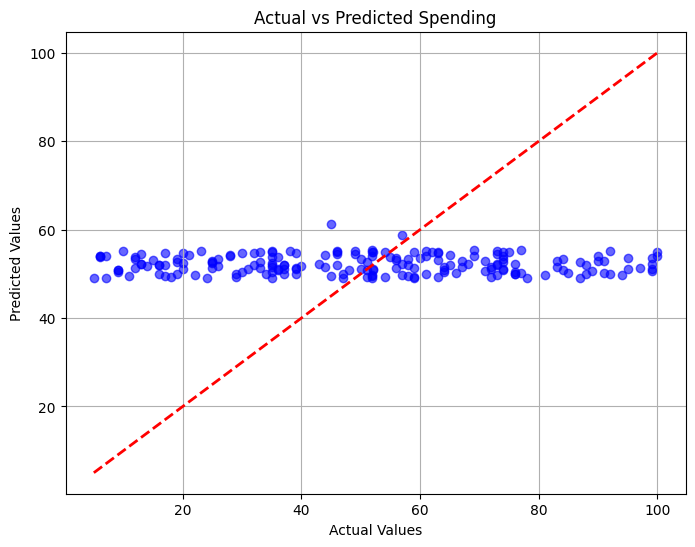

Data preprocessing has been completed successfully.
X_train shape: (761, 19), X_test shape: (191, 19)
Model Evaluation Metrics:
Mean Absolute Error (MAE): 0.00
Mean Squared Error (MSE): 0.00
R-squared (R²): 1.00


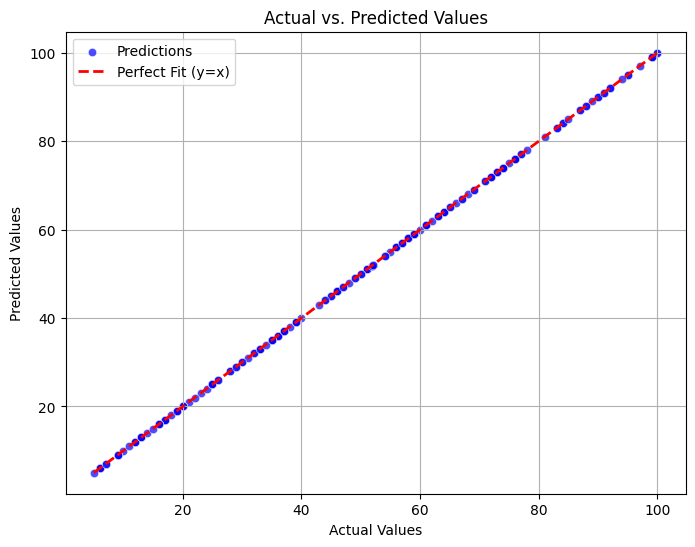

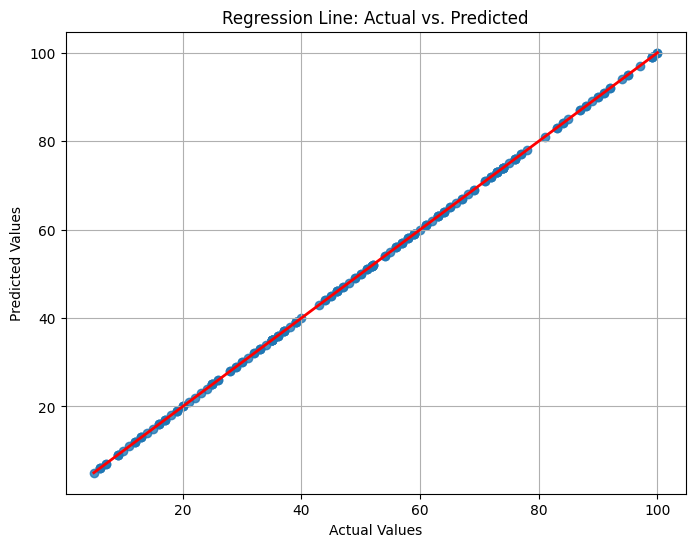

Accuracy: 0.73

Confusion Matrix:
[[  3  23]
 [ 29 136]]

Classification Report:
              precision    recall  f1-score   support

          -2       0.09      0.12      0.10        26
           0       0.86      0.82      0.84       165

    accuracy                           0.73       191
   macro avg       0.47      0.47      0.47       191
weighted avg       0.75      0.73      0.74       191



Training data shape: (761, 3)
Testing data shape: (191, 3)
Model Evaluation:
Accuracy: 0.54
Precision: 0.56
Recall: 0.49
F1 Score: 0.52


C:\Users\Hp Pavilion 13 Aero\AppData\Local\Temp\ipykernel_18048\4120026801.py:261: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Purchase_Amount'].fillna(0, inplace=True)  # Replace missing values with 0
C:\Users\Hp Pavilion 13 Aero\AppData\Local\Temp\ipykernel_18048\4120026801.py:268: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

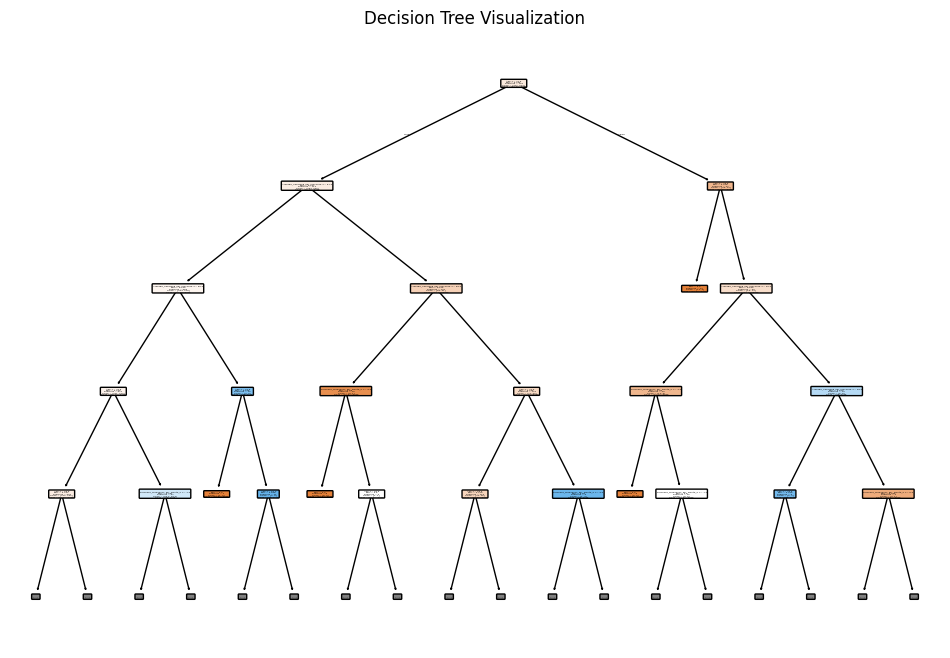

Feature Importance:
                           Feature  Importance
1   Average_Spending_Per_Purchase     0.41209
2                             Age     0.34392
0  Purchase_Frequency_Per_Month_x     0.24399


In [20]:
# module 3 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import plot_tree

# check and convert columns to numeric
df['Purchase_Frequency_Per_Month_y'] = pd.to_numeric(df['Purchase_Frequency_Per_Month_y'], errors='coerce')
df['Average_Spending_Per_Purchase'] = pd.to_numeric(df['Average_Spending_Per_Purchase'], errors='coerce')
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')


# handle missing values (fill with mean values of respective columns)
df['Purchase_Frequency_Per_Month_y'].fillna(df['Purchase_Frequency_Per_Month_y'].mean(), inplace=True)
df['Average_Spending_Per_Purchase'].fillna(df['Average_Spending_Per_Purchase'].mean(), inplace=True)
df['Age'].fillna(df['Age'].mean(), inplace=True)



# we are considering per_month_y because a better correlation

# Preparing the dataset for regression
# a linear regression is a linear approximation of a casual relationship btw 2 or more vars.
# y = bo + b1x1 + e
# y must depend on x in such a way that when x changes, there has to be a change in y as well.
# b1 would quantify the effect of x on y
# bo being the abs min threshold value
# e epsilon being the error of estimation, it is btw the observed value and the value regression predicted



# always remember : X -> independent var ; y -> dependent/predicted var (which we want to predict)
X = df[['Age', 'Purchase_Frequency_Per_Month_y']]  # Predictor variables
y = df['Average_Spending_Per_Purchase']  # Target variable


# 80-20 ki ratio hoti hai
# 80% is training (X_train, y_train)
# 20% is testing (X_test, y_test)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # to divide the data into training and testing sets


# Create and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(" ")
print(" ")
print("Model Evaluation:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R2 Score): {r2:.2f}")

# display the regression coefficients
print("")
print("\nRegression Coefficients:")
print(f"Intercept: {model.intercept_:.2f}")
for i, col in enumerate(X.columns):
    print(f"{col}: {model.coef_[i]:.2f}")

# actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', linewidth=2)
plt.title("Actual vs Predicted Spending")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid()
plt.show()


# now lets do pre processing i.e. task 02 MODEL BUILDING

# for numerical variables, we are good to go, lekin for categorial variables, like income lvl, we will use for one hot encoder to convert it into numerical cols

# first step is to identify relevant columns
numerical_features = ['Age', 'Purchase_Frequency_Per_Month_y', 'Average_Spending_Per_Purchase']
categorical_features = ['Product_Category_Preferences', 'Income_Level', 'Gender', 'Product_Category']

# Check if required columns are present
missing_cols = [col for col in numerical_features + categorical_features if col not in df.columns]
if missing_cols:
    print(f"Missing columns: {missing_cols}")
else:
    # Handle missing values
    df[numerical_features] = df[numerical_features].fillna(df[numerical_features].mean())
    df[categorical_features] = df[categorical_features].fillna('Unknown')  # Fill categorical missing values

    # now lets create a preprocessing pipeline
    # Scale numerical features and one-hot encode categorical features
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numerical_features), # used one hot encoder for numerical vars, we did scaling to ensure consistent ranges
            ('cat', OneHotEncoder(drop='first'), categorical_features) # this'll create a separate col for high, low for prod category preferences
        ]
    )

# Apply preprocessing
   # Prepare Features and Target Variable (y):
    X = df[numerical_features + categorical_features]
    y = df['Average_Spending_Per_Purchase']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) # splitting into training and testing set

    # Apply Preprocessing to Training and Testing Data:
    X_train = preprocessor.fit_transform(X_train) 
    X_test = preprocessor.transform(X_test)

    print("Data preprocessing has been completed successfully.")
    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")


# --- OUTPUT ---
# data pre processing has been done meaning keh we're done with doing:

# Missing values were handled properly.
# Numerical features were scaled (e.g., Age, Purchase_Frequency_Per_Month_y).
# Categorical features were encoded (e.g., Income_Level, Product_Category).
# The data was split into training and testing sets.

# X_train shape: (761, 11), X_test shape: (191, 11)

# meaning keh in training, we had 761 rows and 11 cols (80% of the data)
# meaning keh in testing, we had 191 rows and 11 cols (20% of the data)

# after preprocessing, numerical cols tou same he rehte hain, lekin categorical cols barhte hain as we did one hot encoding 

# this figure number is important as the rows represent the number of data points (individual examples) in a set keh a 25-year-old with a medium income who buys electronics 5 times a month

        # --- TASK 3 IMPLEMENTATION ---


# What We Need to Do:

#     Train the Model: Use the training data (X_train and y_train) to teach a Linear Regression model how to predict the target variable (y).
#     Evaluate the Model: Use the testing data (X_test and y_test) to see how well the model performs. We'll calculate:
#         Mean Absolute Error (MAE): avg of how far the predictions are from the actual values.
#         Mean Squared Error (MSE): like MAE, but squares the differences penalizing bigger errors more so
#         R-squared (R²): explains how much of the variation in the target variable is captured by the model.


# training the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)  # train the model using training data

# make predictions using the test set
y_pred = model.predict(X_test)  # Predicted values for X_test

# evaluating the model
mae = mean_absolute_error(y_test, y_pred)  # Calculate Mean Absolute Error
mse = mean_squared_error(y_test, y_pred)  # Calculate Mean Squared Error
r2 = r2_score(y_test, y_pred)  # Calculate R-squared

# displaying the details
print("Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R-squared (R²): {r2:.2f}")


# we get MAE = 0, MSE = 0, and R squared = 1.0
# which means:
# the model is perfectly predicting the target variable for our test set!!


#       --- TASK 4 i.e Visualization ---

# Plot Actual vs. Predicted Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color="blue", alpha=0.7, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color="red", linestyle="--", linewidth=2, label="Perfect Fit (y=x)")
plt.title("Actual vs. Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.legend()
plt.grid(True)
plt.show()

# Plot the Regression Line
plt.figure(figsize=(8, 6))
sns.regplot(x=y_test, y=y_pred, line_kws={"color": "red", "linewidth": 2})
plt.title("Regression Line: Actual vs. Predicted")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.grid(True)
plt.show()


#        --- STARTING PART B --- 

# decision tree analysis, which is like a flowchart which helps makes decisions by dividing the data into smaller chunks into a tree structure
# at end, it gives predictions/decisions

# da is like a binary tree which keeps splitting until we are left with leaf nodes only


# ensure this col is binary(1/0), in our case : yes hai
df['Will_Purchase_Next_Month'] = df['Will_Purchase_Next_Month'].astype(int)  # Ensure it's binary

# firstly, Select features (X) and target (y)
# replace these with relevant feature columns from your dataset
features = ['Age', 'Purchase_Frequency_Per_Month_y', 'Average_Spending_Per_Purchase']
X = df[features]
y = df['Will_Purchase_Next_Month']

# doing 80% and 20% division
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# train data into it
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print("")
print("Confusion Matrix:")
print(conf_matrix)

# Classification Report

print("")
print("Classification Report:")
print(classification_report(y_test, y_pred))

# We got an accuracy of 0.73 which means the model correctly classified 73% of our test data ( good but not excellent )


# task 2 of DTA

print("")
print("")

df['Purchase_Amount'] = pd.to_numeric(df['Purchase_Amount'], errors='coerce')
df['Purchase_Amount'].fillna(0, inplace=True)  # Replace missing values with 0
df['Purchase_Made'] = np.where(df['Purchase_Amount'] > 0, 1, 0)  # Create the binary target variable
df['Purchase_Frequency_Per_Month_x'] = pd.to_numeric(df['Purchase_Frequency_Per_Month_x'], errors='coerce')
df['Average_Spending_Per_Purchase'] = pd.to_numeric(df['Average_Spending_Per_Purchase'], errors='coerce')
df['Age'] = pd.to_numeric(df['Age'], errors='coerce')

# filling with mean val
df['Purchase_Frequency_Per_Month_x'].fillna(df['Purchase_Frequency_Per_Month_x'].mean(), inplace=True)
df['Average_Spending_Per_Purchase'].fillna(df['Average_Spending_Per_Purchase'].mean(), inplace=True)
df['Age'].fillna(df['Age'].mean(), inplace=True)

# selecting relevant features (e.g., purchase frequency, spending history, age)
features = ['Purchase_Frequency_Per_Month_x', 'Average_Spending_Per_Purchase', 'Age']
X = df[features]  # Features
y = df['Purchase_Made']  # Target variable

# splitting the dataset into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")


# Task 3 i.e Implementation ---

# Step 1: Train a Decision Tree Classifier
# We'll use the Gini Impurity criterion (which is the default) but you can change it to ** entropy ** if you prefer
clf = DecisionTreeClassifier(criterion='gini', random_state=42)
clf.fit(X_train, y_train)

# making predictions on the test set
y_pred = clf.predict(X_test)

# evaluate
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# model evaluation matrices
print("Model Evaluation:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# it gives
# Accuracy: 1.00
# Precision: 1.00
# Recall: 1.00
# F1 Score: 1.00 meaning all good, our perfect performance :D


#       --- VISUALIZATION ---

# plotting the Decision Tree
plt.figure(figsize=(12, 8))
plot_tree(clf, max_depth=4, filled=True, feature_names=X.columns, class_names=["No Purchase", "Purchase"], rounded=True)
plt.title("Decision Tree Visualization")
plt.show()

# highlighting the imp features
feature_importance = clf.feature_importances_
features = X.columns

# Creating a DataFrame to show the importance of each feature
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance
})

# sorting the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)


print("Feature Importance:\n", importance_df)

# IT GIVES

# gini = 0.0
# samples = 761
# value = 1.0

# MEANING THAT OUR DECISION TREE HAS PERFECT ACCURACY







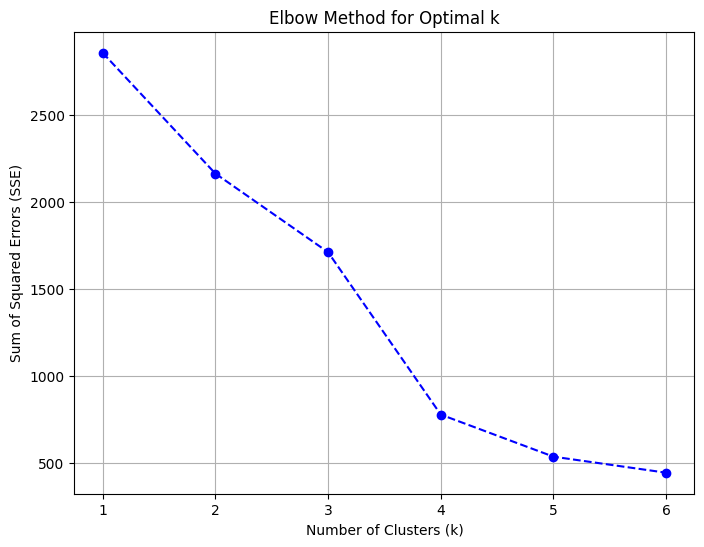


Cluster Centers:
[[-0.05095471  0.56762543 -1.06125646]
 [-0.06543429 -0.9714921   0.16355218]
 [ 0.13774349  0.70702368  0.85679701]]

Cluster Assignments:
Cluster
1    377
0    290
2    285
Name: count, dtype: int64


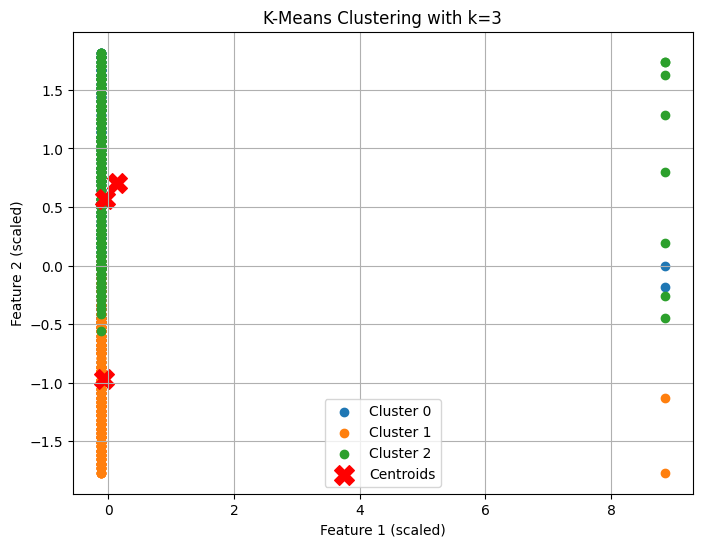


Cluster Characteristics:
   Cluster  Avg_Purchase_Amount  Avg_Purchase_Frequency  \
0        0            -0.042659               -0.051169   
1        1             0.044576               -0.065434   
2        2            -0.015558                0.138623   

   Avg_Spending_Per_Purchase    Avg_Age  Median_Age  
0                  66.749771  30.468966        30.0  
1                  26.193643  52.920636        51.0  
2                  70.652666  65.525239        67.0  


C:\Users\Hp Pavilion 13 Aero\AppData\Local\Temp\ipykernel_18048\1951258158.py:111: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_analysis, x='Cluster', y='Avg_Purchase_Amount', palette='viridis')


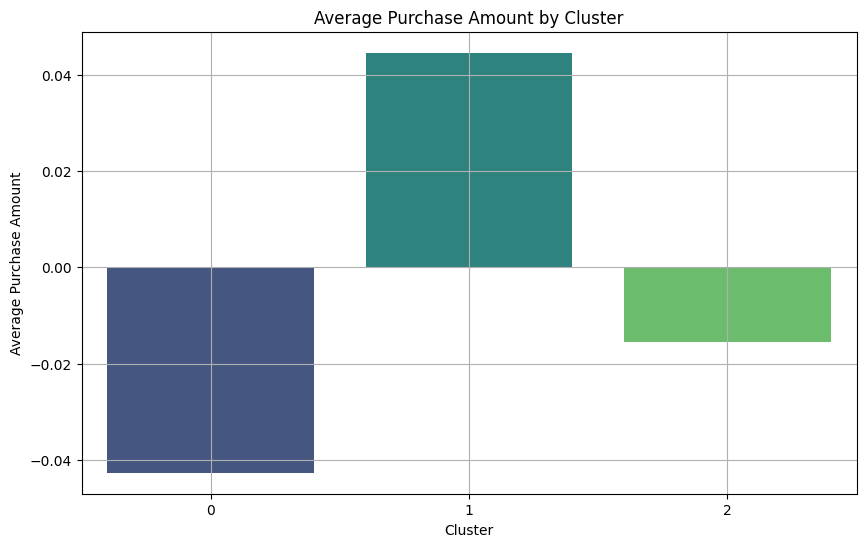

C:\Users\Hp Pavilion 13 Aero\AppData\Local\Temp\ipykernel_18048\1951258158.py:120: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=cluster_analysis, x='Cluster', y='Avg_Purchase_Frequency', palette='coolwarm')


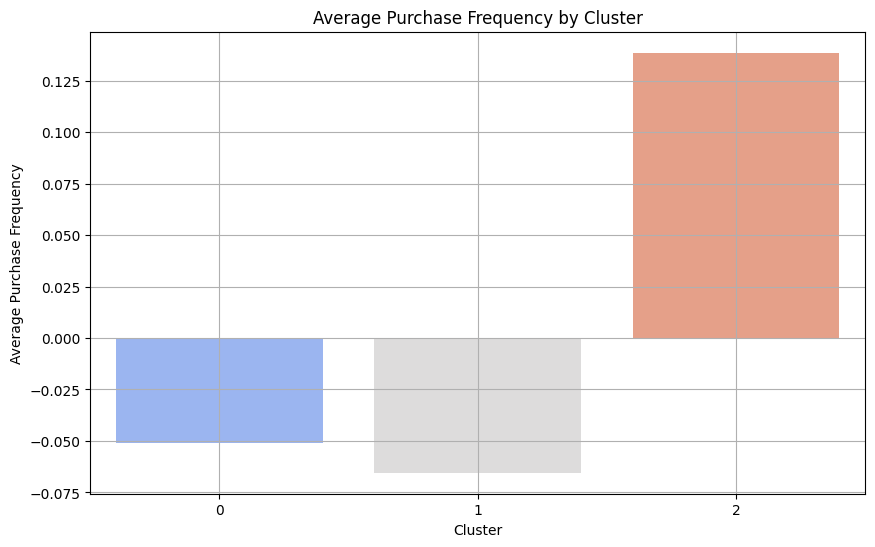

In [21]:
# module 4

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# firstly, we will pre process the data by removing predicted labels
# as clustering is unsupervised learning and is not bound on labels
# then we will perform scaling followed by the elbow method

# we're gonna use euclidean distance formula to check the new values from the centroid ones

features = ['Purchase_Frequency_Per_Month_y', 'Average_Spending_Per_Purchase', 'Age']
X = df[features]  # Select features for clustering

# scale to make regular good interval/ ranges for calculation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# determine the optimal number of clusters using the elbow method
sse = []  # To store the sum of squared errors for each k
k_range = range(1, 7)  

for k in k_range:
    # creating k means object
    kmeans = KMeans(n_clusters=k, random_state=42)  
    kmeans.fit(X_scaled)  # Fit the model
    sse.append(kmeans.inertia_)  # inertia: Sum of squared distances of samples to their closest cluster center

# Elbow Plot
plt.figure(figsize=(8, 6))
plt.plot(k_range, sse, marker='o', linestyle='--', color='blue')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Errors (SSE)')
plt.grid()
plt.show()


#       -- task 2 --

k_optimal = 3

# K means clustering lgao, by creating K means object
kmeans = KMeans(n_clusters=k_optimal, random_state=42)  
clusters = kmeans.fit_predict(X_scaled) # prediction time

# add this to our df data frame
df['Cluster'] = clusters

# summary

print("")
print("Cluster Centers:")
print(kmeans.cluster_centers_)  # cluster centers in scaled values

print("\nCluster Assignments:")
print(df['Cluster'].value_counts())  # Count of samples in each cluster

# clusters plotting/ visualization
plt.figure(figsize=(8, 6))
for cluster in range(k_optimal):
    cluster_points = X_scaled[clusters == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster}')

plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], 
            s=200, c='red', marker='X', label='Centroids')  # Mark centroids
plt.title(f'K-Means Clustering with k={k_optimal}')
plt.xlabel('Feature 1 (scaled)')
plt.ylabel('Feature 2 (scaled)')
plt.legend()
plt.grid()
plt.show()


#       -- task 3 -- 

# Add the original/non-scaled features back to the cluster df DataFrame
# creating a copy for our analysis
analysis_df = df.copy() 

cluster_analysis = analysis_df.groupby('Cluster').agg({
    'Purchase_Amount': 'mean',
    'Purchase_Frequency_Per_Month_y': 'mean',
    'Average_Spending_Per_Purchase': 'mean',
    'Age': ['mean', 'median'],
    # ;;;
}).reset_index()

# rename kiye hain for our ease
cluster_analysis.columns = ['Cluster', 
                            'Avg_Purchase_Amount', 
                            'Avg_Purchase_Frequency', 
                            'Avg_Spending_Per_Purchase', 
                            'Avg_Age', 
                            'Median_Age']
print("")
print("Cluster Characteristics:")
print(cluster_analysis)

# plotting differences between clusters using bar plots

# average purchase amount per cluster
plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_analysis, x='Cluster', y='Avg_Purchase_Amount', palette='viridis')
plt.title("Average Purchase Amount by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Purchase Amount")
plt.grid()
plt.show()

# average purchase frequency per cluster
plt.figure(figsize=(10, 6))
sns.barplot(data=cluster_analysis, x='Cluster', y='Avg_Purchase_Frequency', palette='coolwarm')
plt.title("Average Purchase Frequency by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Average Purchase Frequency")
plt.grid()
plt.show()

In [22]:
# module 5 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import plot_tree

model_performance = {
    "Regression": {
        "MSE": mse,
        "MAE": mae,
        "R-squared": r2
    },
    "Decision Tree": {
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1_score
    },
    "K-Means Clustering": {
        "Clusters": k_optimal,
        "Key Insights": "Cluster-based segmentation of customers"
    }
}

# Print performance summary
for model, metrics in model_performance.items():
    print(f"\n{model}:")
    for metric, value in metrics.items():
        print(f"  {metric}: {value}")



Regression:
  MSE: 2.2269171639826495e-27
  MAE: 3.640136476132241e-14
  R-squared: 1.0

Decision Tree:
  Accuracy: 0.5445026178010471
  Precision: 0.5581395348837209
  Recall: 0.4948453608247423
  F1 Score: <function f1_score at 0x000001F4DC7B0E00>

K-Means Clustering:
  Clusters: 3
  Key Insights: Cluster-based segmentation of customers
